In [1]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score ,silhouette_samples
from mpl_toolkits.mplot3d import Axes3D

In [2]:
precess = pd.read_csv("dataset/Books Data with Category Language and Summary/Preprocessed_data.csv")

In [3]:
idx = precess[precess['Category'] == '9'].index
precess.drop(idx , inplace=True) ###카테고리에 9가 있으면 드랍한다.

In [4]:
books = pd.read_csv("dataset/Book reviews/Book reviews/BX_Books.csv", sep=';', encoding="latin-1")
users = pd.read_csv("dataset/Book reviews/Book reviews/BX-Users.csv", sep=';', encoding="latin-1")
ratings = pd.read_csv("dataset/Book reviews/Book reviews/BX-Book-Ratings.csv", sep=';', encoding="latin-1")

In [5]:
# delete special symbols
precess["Category"] = precess["Category"].str.replace(
    pat=r'[^\w]', repl=r' ', regex=True)

In [6]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [7]:
df = precess.loc[:,['user_id','rating','book_title','Category']]
df = df [1:1000]
df.info()

#데이터셋을 나눔

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 1 to 1014
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     999 non-null    int64 
 1   rating      999 non-null    int64 
 2   book_title  999 non-null    object
 3   Category    999 non-null    object
dtypes: int64(2), object(2)
memory usage: 39.0+ KB


In [8]:
df.columns

df.Category

1         Actresses  
2         Actresses  
3         Actresses  
4         Actresses  
5         Actresses  
            ...      
1010        Fiction  
1011        Fiction  
1012        Fiction  
1013        Fiction  
1014        Fiction  
Name: Category, Length: 999, dtype: object

In [9]:
df[df['rating']> 5].shape #rating이 5이상인 데이터 갯수 확인

(297, 4)

In [10]:
df1 = df[df['rating']>5].drop_duplicates() #rating이 5이상인 데이터가 중복된것들이 없게 제거

In [11]:
df1["Category"].nunique() #고유값들의 객수 확인

10

In [12]:
crosstab = pd.crosstab(df1['user_id'],df['Category']).astype('bool') #boolean의 형식으로 이를 교차표로서 계산한다.
freq_item = apriori(crosstab,min_support=0.0001,use_colnames=True) #apriori라이브러리를 불러와 지지가 0.0001이상인것들만불러온다,

rules = association_rules(freq_item, metric = "lift", min_threshold = 0.05) #이를 다시 연관분석하여 향상도 threshold가 0.05이상인 것들로 만들어준다.
rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x)[0])
rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0])

In [13]:
def search_apriori(df1, title):
    string = df1[df1["book_title"] == title]["Category"].iloc[0]
    search_df = rules[rules['antecedents'].str.lower()== string.lower()]
    search_df.sort_values(by='lift', ascending=False)
    search_df = search_df.drop_duplicates()
    arr = search_df[:10]['consequents'].to_list()
    result = []
    for value in arr:
        if value not in result:
            result.append(value)
    recom = []
    for i in result:
        a = df1[df1["Category"] == i]["book_title"].iloc[0]
        recom.append(a)
        
    return recom

In [14]:
recomended = df1
recomended

,user_id,rating,book_title,Category
3,11676,8,Clara Callan,Actresses
5,67544,8,Clara Callan,Actresses
8,116866,9,Clara Callan,Actresses
9,123629,9,Clara Callan,Actresses
11,200273,8,Clara Callan,Actresses
...,...,...,...,...
1002,28591,6,Wild Animus,Fiction
1006,28735,6,Wild Animus,Fiction
1008,28800,7,Wild Animus,Fiction
1009,28804,6,Wild Animus,Fiction


In [25]:
search_apriori(recomended, 'Decision in Normandy')

['New Vegetarian: Bold and Beautiful Recipes for Every Occasion',
 "The Kitchen God's Wife",
 "Our Dumb Century: The Onion Presents 100 Years of Headlines from America's Finest News Source"]

In [26]:
search_apriori(recomended, 'Wild Animus')

['Clara Callan',
 'New Vegetarian: Bold and Beautiful Recipes for Every Occasion',
 "Our Dumb Century: The Onion Presents 100 Years of Headlines from America's Finest News Source",
 'More Cunning Than Man: A Social History of Rats and Man']

In [17]:
mean_users_rating = ratings.groupby('User-ID')['Book-Rating'].mean()
users_rating = ratings.set_index('User-ID')
users_rating['mean-rating'] = mean_users_rating
users_rating.reset_index(inplace = True)
users_rating = users_rating[users_rating['Book-Rating'] > users_rating['mean-rating']]
users_rating['is_fav'] = 1

In [18]:
val = users_rating['User-ID'].value_counts()
list_to_keep = list(val[(val>10) & (val<100)].index)
users_rating = users_rating[users_rating['User-ID'].isin(list_to_keep)]
users_rating.shape

(154395, 5)

In [19]:
df = pd.pivot_table(users_rating, index = 'User-ID', columns = 'ISBN', values = 'is_fav')
df.fillna(value = 0, inplace = True)
df.shape

(5480, 83889)

In [20]:
pca = PCA(n_components = 3)
pca.fit(df)
pca_fit = pca.transform(df)

pca_fit = pd.DataFrame(pca_fit, index = df.index)
pca_fit

,0,1,2
User-ID,,,
183,-0.228461,-0.023079,0.051571
242,-0.192121,-0.015937,0.036545
243,0.327410,-0.244330,-0.176240
254,0.819981,1.863720,0.200887
388,-0.136912,-0.032031,0.015336
...,...,...,...
278554,-0.130536,-0.050357,0.013677
278582,0.006407,-0.088140,-0.098269
278633,0.765736,-0.474937,0.718475


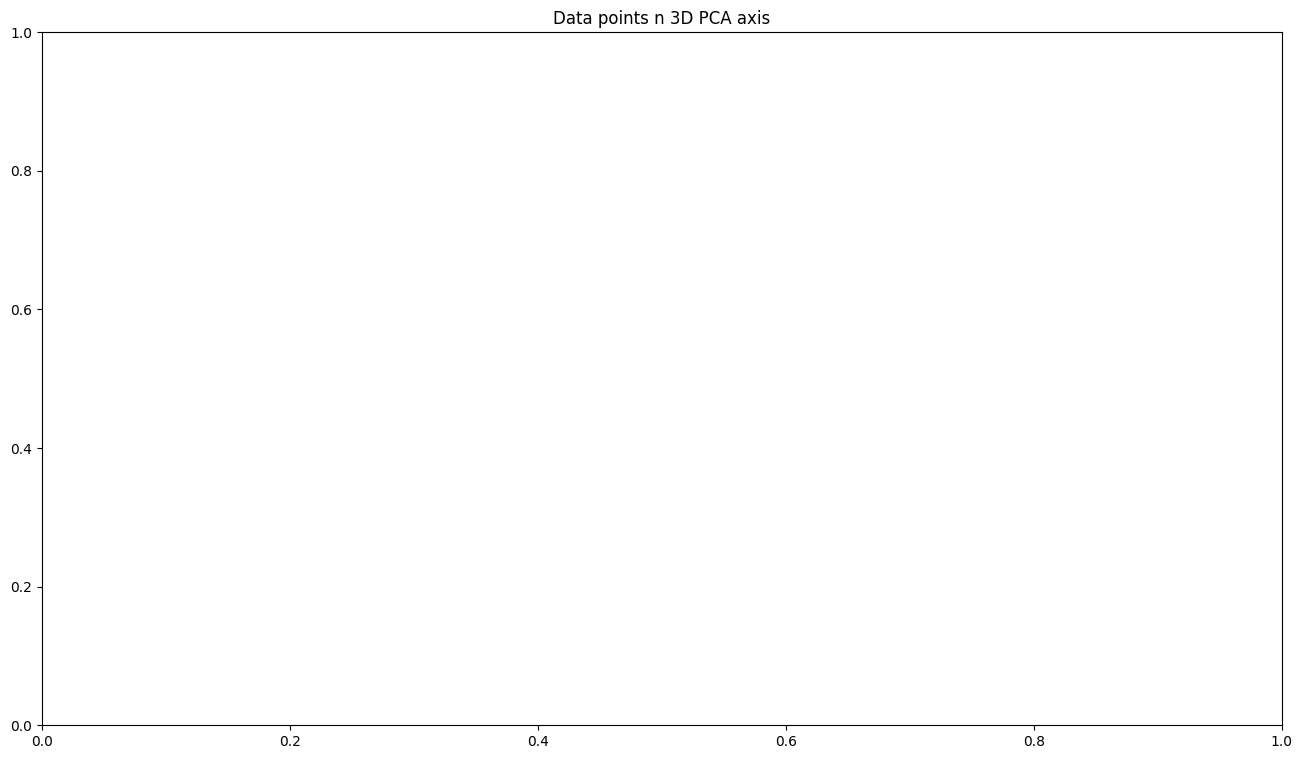

In [21]:
km = KMeans(n_clusters = 3)
plt.rcParams['figure.figsize'] = (16, 9)
clusters =km.fit_predict(pca_fit)
cmhot = plt.get_cmap('brg')
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca_fit[0], pca_fit[2], pca_fit[1], c = clusters, cmap = cmhot)
plt.title('Data points n 3D PCA axis')
plt.show()

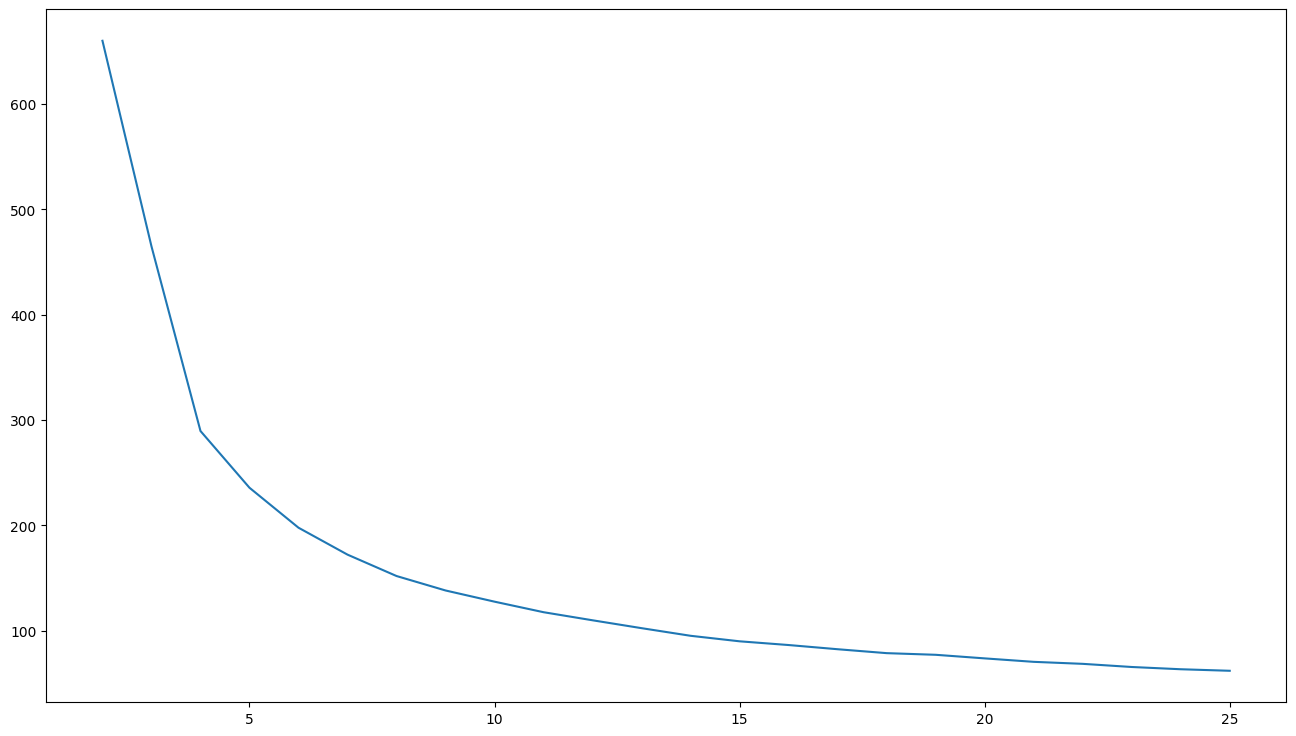

In [22]:
tss = []
for i in range(2, 26):
    km = KMeans(n_clusters = i, random_state = 0)
    km.fit(pca_fit)
    tss.append(km.inertia_)
plt.plot(range(2, 26), tss, '-')
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.6745685175114305
For n_clusters = 4 The average silhouette_score is : 0.667070355755454
For n_clusters = 5 The average silhouette_score is : 0.5851614015918013
For n_clusters = 6 The average silhouette_score is : 0.6075888100283269
For n_clusters = 7 The average silhouette_score is : 0.5951157956992535
For n_clusters = 8 The average silhouette_score is : 0.5405267159544344


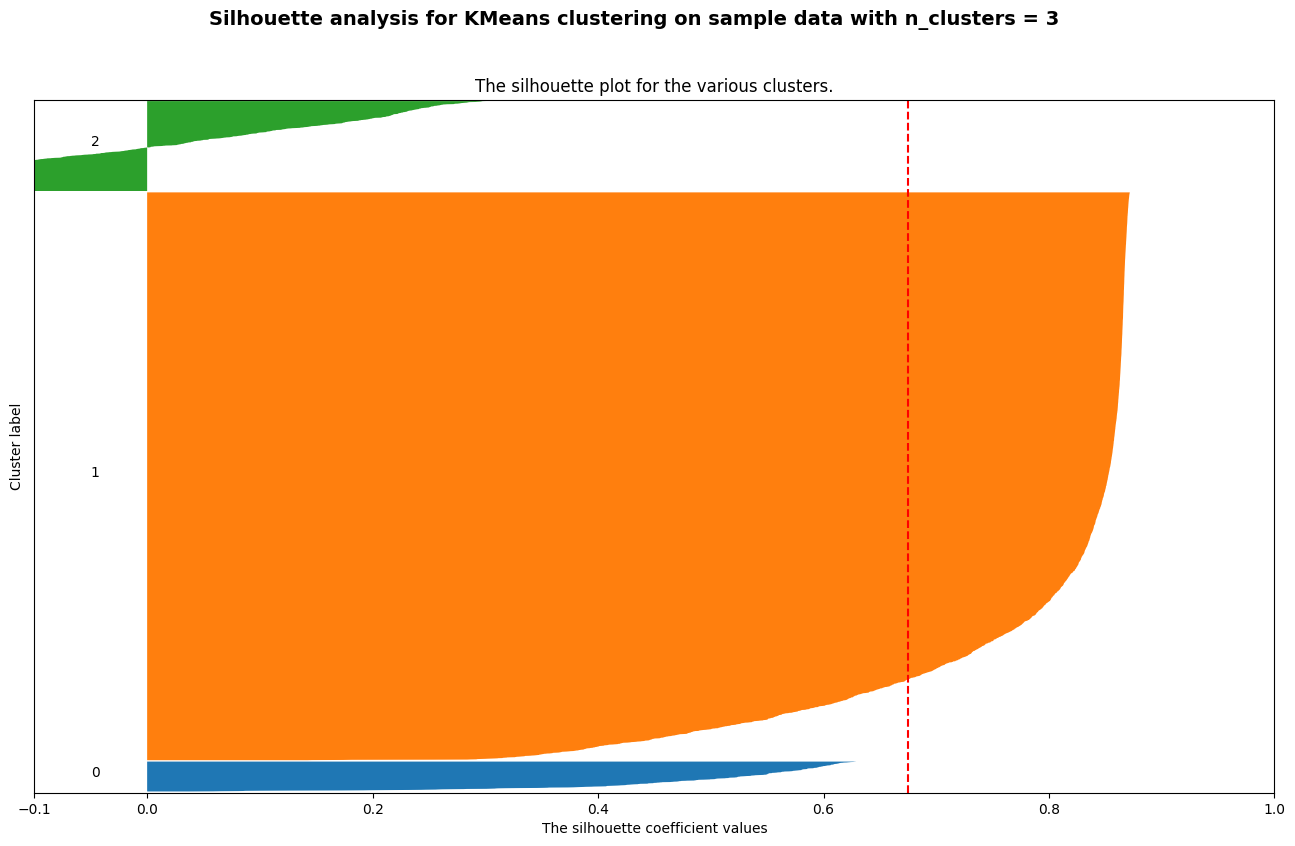

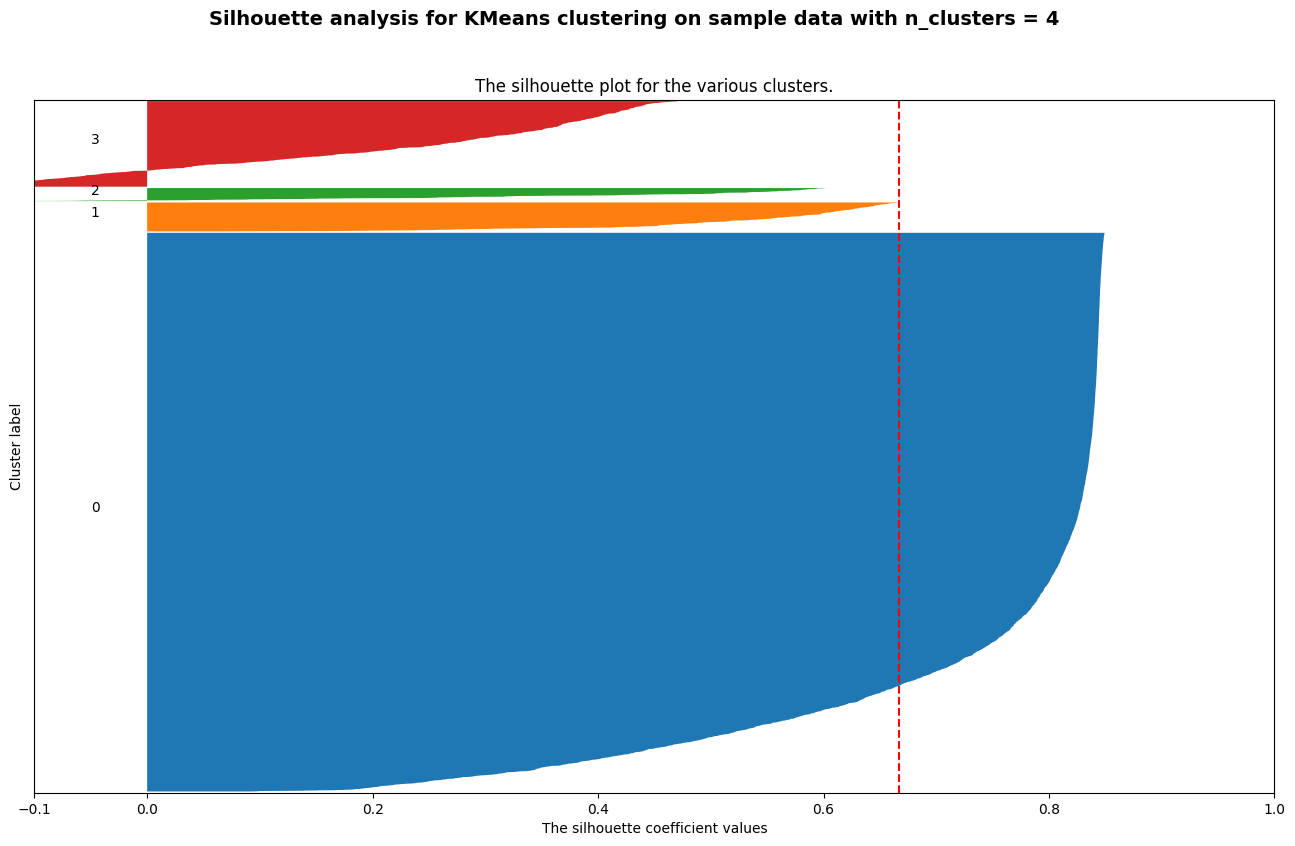

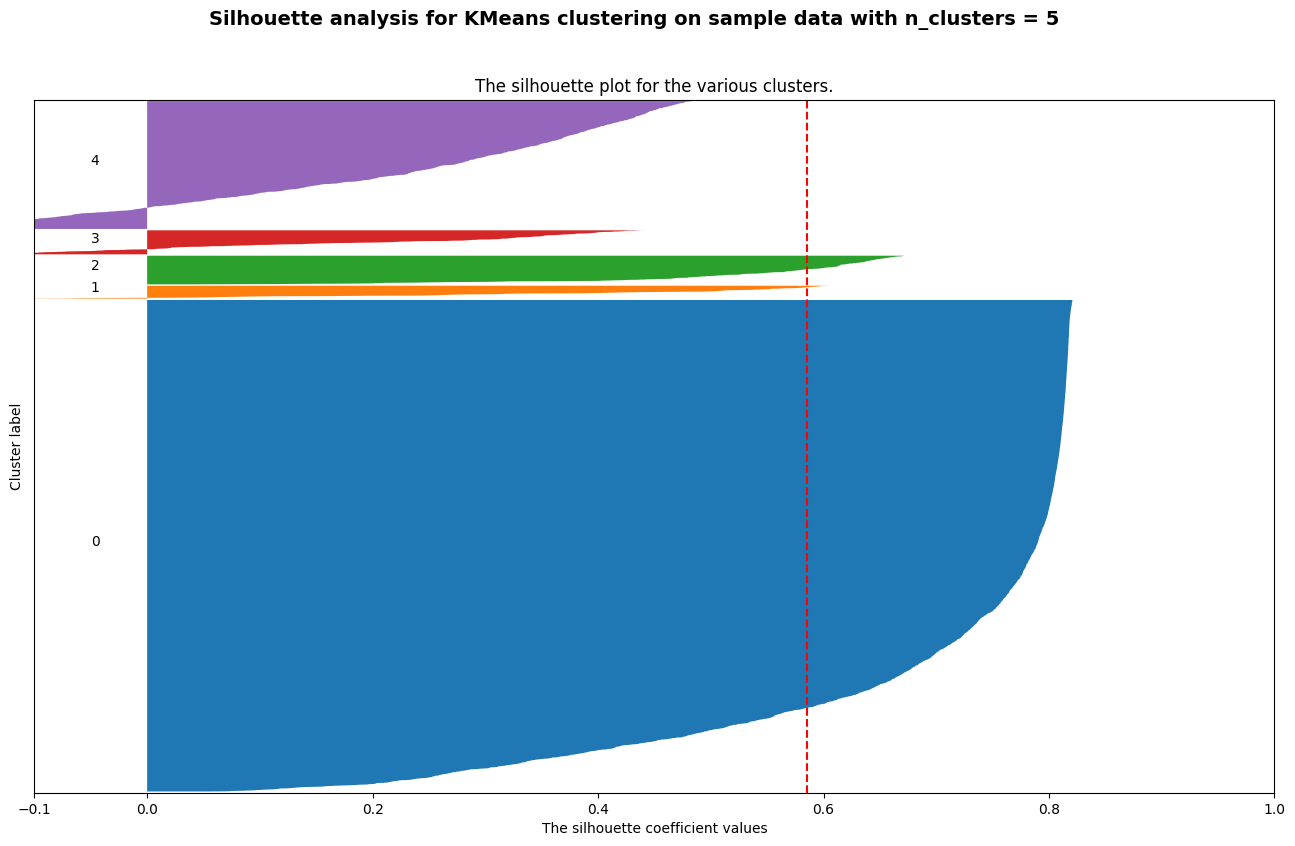

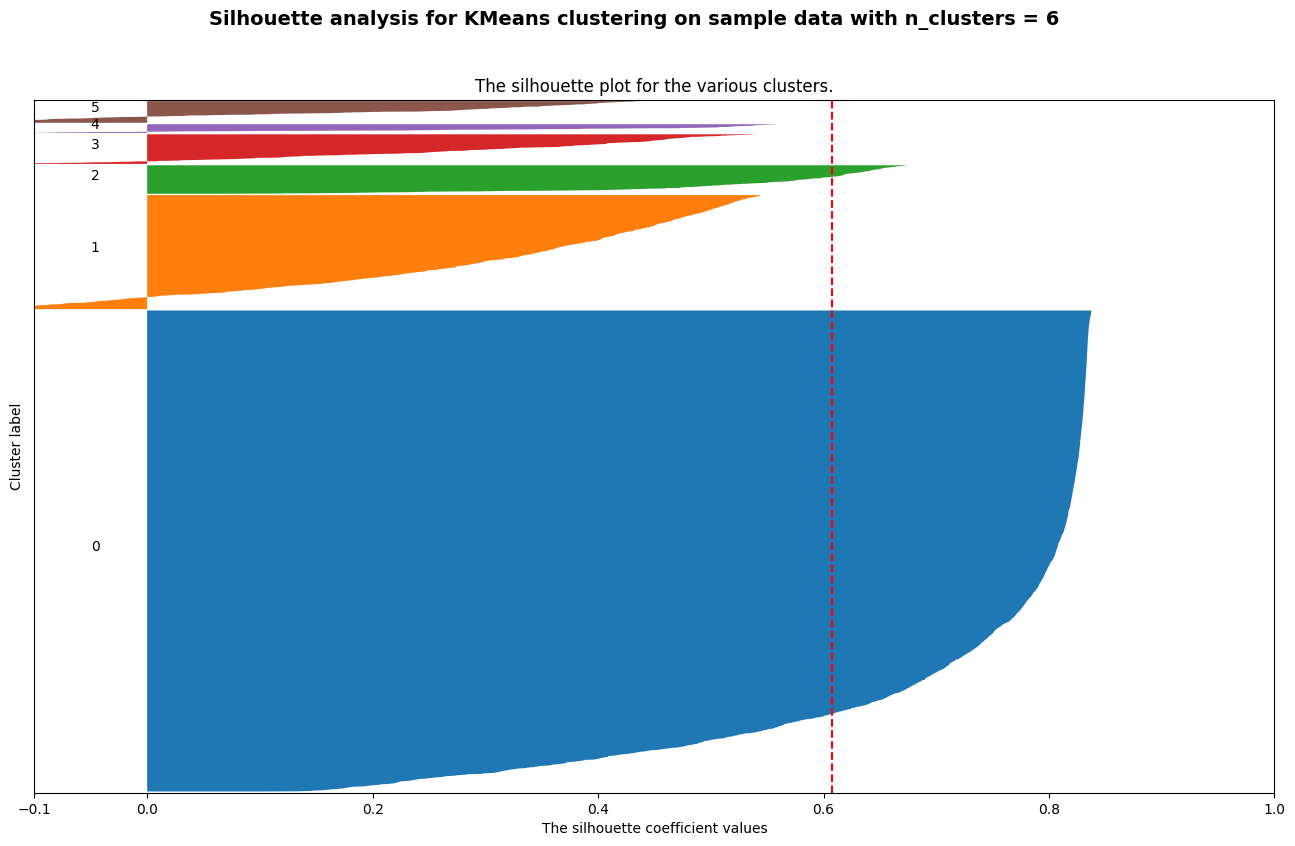

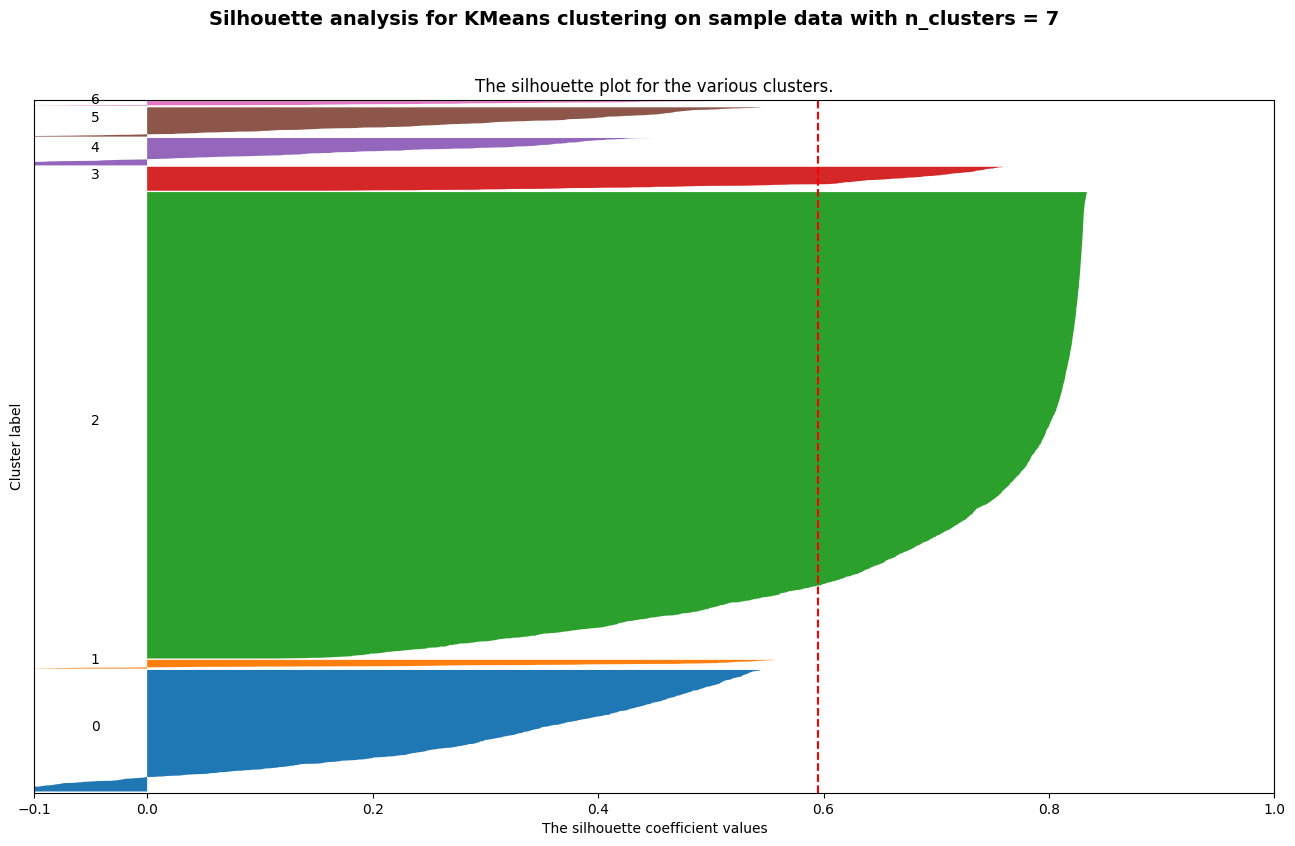

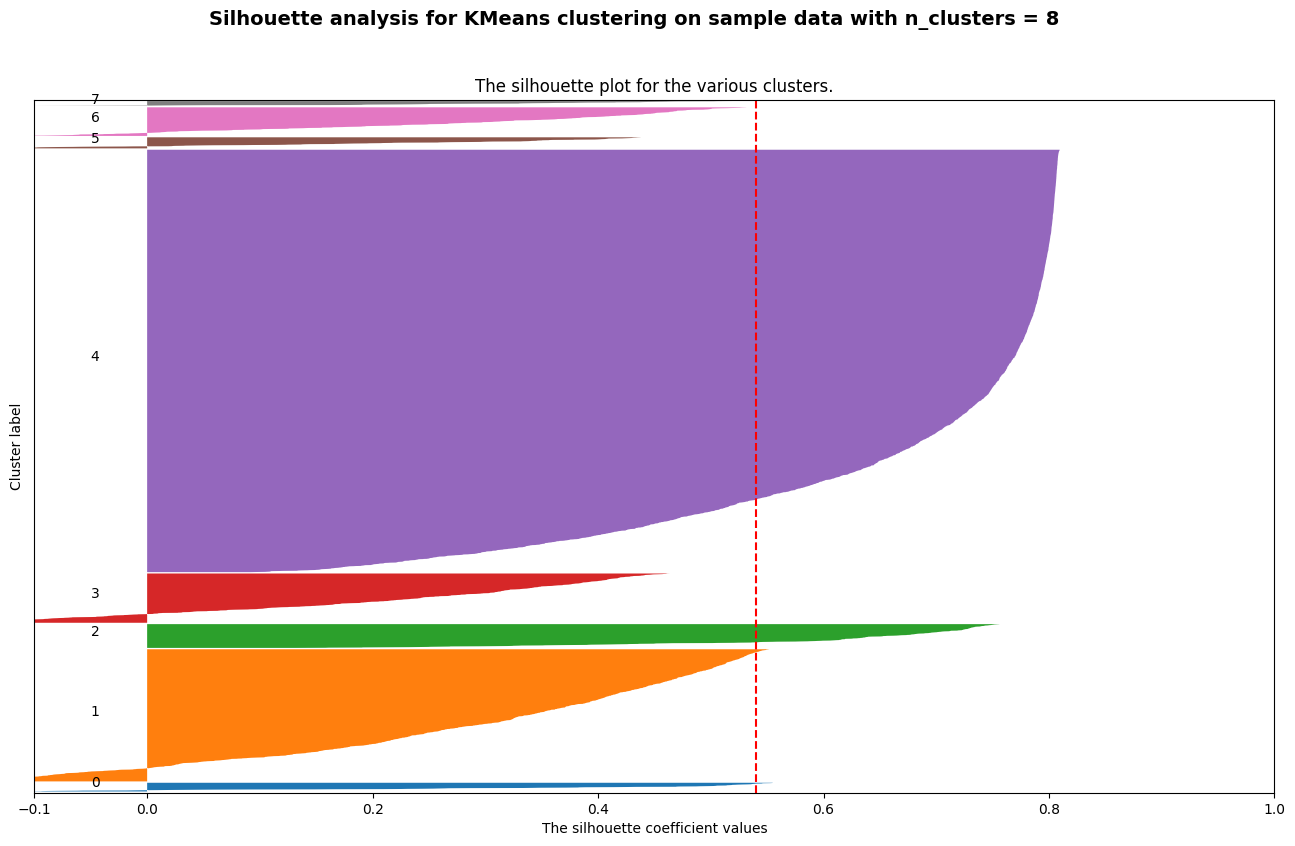

In [23]:
for n in [3,4,5,6,7,8]:
    ax1 = plt.figure().gca()
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pca_fit) + (n + 1) * 10])
    km = KMeans(n_clusters=n,random_state=0)
    clusters = km.fit_predict(pca_fit)
    silhouette_avg = silhouette_score(pca_fit, clusters)
    print("For n_clusters =", n,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_values = silhouette_samples(pca_fit, clusters)
    y_start = 10
    for i in range(n): 
        ith_cluster = np.sort(silhouette_values[clusters==i])
        cluster_size = ith_cluster.shape[0]
        y_end = y_start + cluster_size 
        ax1.fill_betweenx(np.arange(y_start, y_end),
                          0, ith_cluster)
        ax1.text(-0.05, y_start + 0.5 * cluster_size, str(i))
        y_start = y_end + 10
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n),
                 fontsize=14, fontweight='bold')
plt.show()

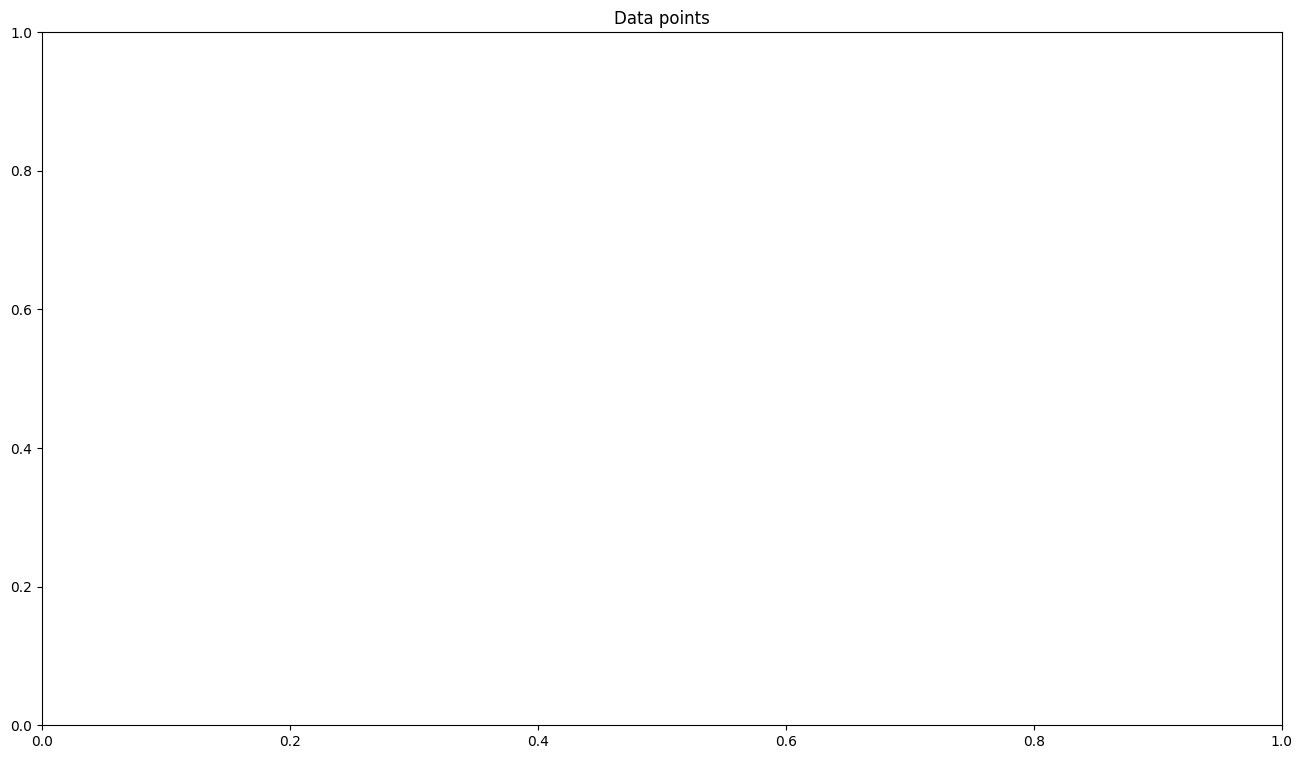

In [24]:
kmeans_4 = KMeans(n_clusters = 4, random_state = 0).fit(pca_fit)
df['cluster'] = kmeans_4.labels_
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca_fit[0], pca_fit[2], pca_fit[1], c = df['cluster'], cmap = cmhot)
plt.title('Data points')
plt.show()